Starting simulation for Da = 1e-06
14 4.6269209438230433e-10 0.00012345679012345682 0.0001278428330963347
0.9986584434879808
Starting simulation for Da = 0.0001
1000 1.835317850112915 3.2359524002579427e-09
1077 9.870305910467433e-10 0.00012345679012345682 0.00012312000970702186
0.9972720786268768
Starting simulation for Da = 0.001
1000 1.6481494903564453 0.0004144938885376302
2000 4.2350311279296875 6.621168440846498e-05
3000 7.433099269866943 1.1735505995829889e-05
4000 10.41594672203064 2.103241942704981e-06
5000 14.600043773651123 3.7710964171699374e-07
6000 16.837816953659058 6.759116617745935e-08
7000 18.374346494674683 1.2112372035760383e-08
8000 19.895097255706787 2.170455546294666e-09
8451 9.998186042327981e-10 0.00012345679012345682 0.00012189160665496215
0.987322013904772


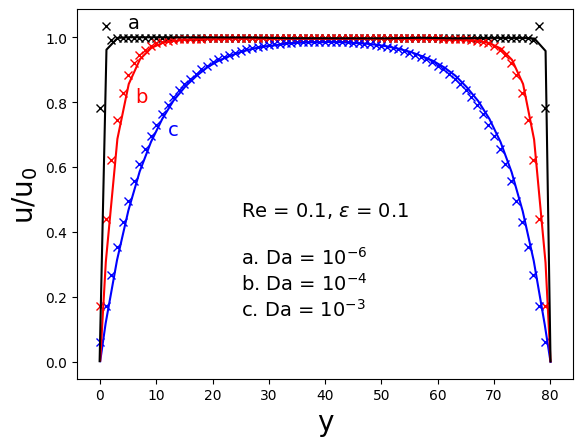

In [1]:
# Poiseuille flow - change darcy number

import numpy as np
import time
import matplotlib.pyplot as plt

# !pip install tikzplotlib
# import tikzplotlib

nx = 80
ny = 80
Darcy = [1e-6, 1e-4, 1e-3]
Gx_ = [0.001880, 0.00001885, 0.000001910]
y = []
u = []
for i in range(3):

    start = time.time()

    # Simulation parameters

    tau = 0.8
    omega = 1/tau
    cssq = 1/3
    nu = cssq*(tau - 0.5)

    tol = 1e-9
    relerror = 1

    eps = 0.1
    Re = 0.1
    Da = Darcy[i]
    H = ny + 1
    umax = Re*nu/H
    K = Da*H**2 # eqna 5
    Feps = 1.75/(150*eps**3)**0.5

    c0 = 0.5*(1 + eps*0.5*nu/K)
    c1 = eps*0.5*Feps/(K**0.5)

    # D2Q9 lattice arrangement
    ndir = 9
    w = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
    cx = np.array([0, 1, -1, 0, 0, 1, -1, -1, 1])
    cy = np.array([0, 0, 0, 1, -1, 1, 1, -1, -1])

    # Simulation initialisation
    rho = np.ones((nx, ny))

    ux = np.zeros((nx, ny))
    uy = np.zeros((nx, ny))
    uxold = np.zeros((nx, ny))
    uyold = np.zeros((nx, ny))
    feq = np.zeros((ndir, nx, ny))
    Fdist = np.zeros((ndir,nx,ny))

    Gx = Gx_[i]
    Fx = eps*Gx

    for k in range(ndir):
        feq[k, :, :] = w[k]
        dotprodF = cx[k]*Fx
        Fdist[k, :, :] = w[k]*rho*(1-0.5*omega)*dotprodF/cssq

    f = np.copy(feq)
    fold = np.copy(feq)

    t = 0

    print('Starting simulation for Da =',Da)

    # Simulation loop
    while relerror > tol:

        # Collision
        f = (1 - omega)*fold + omega*feq + Fdist

        # Streaming - Explicit version
        # automatically applies periodic boundary conditions in all edges of computation domain
        for k in range(ndir):
          fold[k, :, :] = np.roll(np.roll(f[k, :, :], cx[k], axis = 0), cy[k], axis = 1)

        # Boundary conditions
        # No-slip boundary condition on the bottom and top walls (in the y-axis)
        # Implemented by half-way bounce-back
        fold[3, :, 0] = f[4, :, 0]
        fold[5, :, 0] = f[7, :, 0]
        fold[6, :, 0] = f[8, :, 0]

        fold[4, :, ny - 1] = f[3, :, ny - 1]
        fold[7, :, ny - 1] = f[5, :, ny - 1]
        fold[8, :, ny - 1] = f[6, :, ny - 1]

        # Macroscopic variables: density, velocity, forces
        rho = fold[0, :, :] + fold[1, :, :] + fold[2, :, ] + fold[3, :, :] + fold[4, :, :] + fold[5, :, :] + fold[6, :, :] + fold[7, :, :] + fold[8, :, :]
        vx = np.zeros((nx, ny))
        vy = np.zeros((nx, ny))

        for k in range(ndir):
            vx += cx[k]*fold[k, :, :]
            vy += cy[k]*fold[k, :, :]


        vx = vx/rho + 0.5*eps*Gx
        vy /= rho
        vmagn = (vx**2 + vy**2)**0.5

        ux = vx / (c0 + (c0**2 + c1*vmagn)**0.5)
        uy = vy / (c0 + (c0**2 + c1*vmagn)**0.5)
        umagn = (ux**2 + uy**2)**0.5


        Fx = -eps*nu*ux/K - eps*Feps*umagn*ux/(K**0.5) + eps*Gx
        Fy = -eps*nu*uy/K - eps*Feps*umagn*uy/(K**0.5)

        # Equilibrium distribution function (+ force term)
        for k in range(ndir):
            dotprod = cx[k]*ux + cy[k]*uy
            udotu = ux**2 + uy**2
            dotprodF = cx[k]*Fx + cy[k]*Fy
            udotF = ux*Fx + uy*Fy
            feq[k, :, :] = w[k]*rho*(1 + dotprod/cssq + dotprod**2/(2*eps*cssq**2) - udotu/(2*eps*cssq))

            Fdist[k, :, :] = w[k]*rho*(1-0.5*omega)*(dotprodF/cssq + (dotprod*dotprodF)/(eps*cssq**2) - udotF/(eps*cssq))


        # Computing relative error
        num = ((ux - uxold)**2 + (uy - uyold)**2)**0.5
        relerror = np.max(num/umagn)

        uxold = ux
        uyold = uy

        t += 1

        if t % 1000 == 0:
            print(t, time.time()-start, relerror)

    print(t, relerror, umax, np.max(ux))

    umagn = np.sqrt(ux**2 + uy**2)

    y.append(umagn[nx//2, :]/umax)
    u.append(umagn[nx//2, ny//2]/umax)

    print(umagn[nx//2, ny//2]/umax)


x = range(0, ny)
xy0 = np.array((0.00049, 0.00122, 0.01253, 0.11791, 0.03783, 0.31299, 0.06304, 0.46612, 0.08818, 0.58643, 0.11326, 0.67756, 0.13829, 0.74862, 0.16329, 0.80510, 0.18958, 0.84881, 0.21452, 0.88158, 0.23946, 0.90888, 0.26438, 0.92888, 0.28929, 0.94342, 0.31420, 0.95612, 0.33909, 0.96519, 0.36529, 0.97242, 0.39018, 0.97601, 0.41507, 0.98143, 0.43995, 0.98319, 0.46483, 0.98496, 0.48971, 0.98490,
                0.51459, 0.98667, 0.53946, 0.98479, 0.56434, 0.98291, 0.58921, 0.98103, 0.61408, 0.97733, 0.64025, 0.97179, 0.66511, 0.96444, 0.68997, 0.95527, 0.71482, 0.94245, 0.73967, 0.92780, 0.76450, 0.90768, 0.78932, 0.88209, 0.81412, 0.84739, 0.84021, 0.80356, 0.86497, 0.74879, 0.88969, 0.67761, 0.91437, 0.58454, 0.93898, 0.46412, 0.96352, 0.31088, 0.98797, 0.11386, 1.00081, -0.00106))
x0 = xy0[::2]*80
y0 = xy0[1::2]
xy1 = np.array((0.00050, 0.00304, 0.01294, 0.30757, 0.03865, 0.68684, 0.06390, 0.85639, 0.08894, 0.93293, 0.11389, 0.96752, 0.14012, 0.98388, 0.16500, 0.98929, 0.18989, 0.99288, 0.21477, 0.99465, 0.23965, 0.99459, 0.26452, 0.99454, 0.28941, 0.99630, 0.31428, 0.99625, 0.33916, 0.99619, 0.36535, 0.99613, 0.38891, 0.99608, 0.41510, 0.99602, 0.43998, 0.99596, 0.46486, 0.99590, 0.48973, 0.99585,
                0.51461, 0.99579, 0.53949, 0.99573, 0.56436, 0.99568, 0.58924, 0.99562, 0.61412, 0.99556, 0.64030, 0.99550, 0.66518, 0.99545, 0.69006, 0.99539, 0.71494, 0.99533, 0.73981, 0.99528, 0.76469, 0.99340, 0.78956, 0.99334, 0.81444, 0.99146, 0.84062, 0.98958, 0.86548, 0.98222, 0.89032, 0.96575, 0.91512, 0.93105, 0.93984, 0.85622, 0.96434, 0.68473, 0.98970, 0.30534, 1.00082, 0.00076))
x1 = xy1[::2]*80
y1 = xy1[1::2]
xy2 = np.array((-0.00082, 0.00122, 0.01437, 0.96228, 0.03933, 0.99870, 0.06421, 1.00046, 0.08909, 1.00041, 0.11396, 1.00035, 0.18860, 1.00018, 0.26454, 1.00001, 0.33917, 0.99984, 0.41510, 0.99784, 0.48974, 0.99767,
                0.51461, 0.99761, 0.56437, 0.99750, 0.64031, 0.99733, 0.71494, 0.99898, 0.78957, 0.99699, 0.86421, 0.99864, 0.91527, 0.99852, 0.94015, 0.99847, 0.96502, 0.99659, 0.98981, 0.95823, 1.00082, 0.00076))
x2 = xy2[::2]*80
y2 = xy2[1::2]
plt.plot(x, y[0], 'kx', label = "Da=1e-6")
plt.plot(x, y[1], 'rx', label = "Da=1e-4")
plt.plot(x, y[2], 'bx', label = "Da=1e-3")
plt.plot(x0, y0, 'b-', label = "Da=1e-3 (ref)")
plt.plot(x1, y1, 'r-', label = "Da=1e-4 (ref)")
plt.plot(x2, y2, 'k-', label = "Da=1e-6 (ref)")
plt.text(25, 0.45, 'Re = 0.1, $\epsilon$ = 0.1', fontsize = 14)
plt.text(25, 0.3, 'a. Da = $\mathregular{10^{-6}}$', fontsize = 14)
plt.text(25, 0.22, 'b. Da = $\mathregular{10^{-4}}$', fontsize = 14)
plt.text(25, 0.14, 'c. Da = $\mathregular{10^{-3}}$', fontsize = 14)
plt.text(5, 1.03, 'a', fontsize = 14, color = 'k')
plt.text(6.2, 0.8, 'b', fontsize = 14, color = 'r')
plt.text(12, 0.7, 'c', fontsize = 14, color = 'b')
plt.xlabel('y', fontsize = 20)
plt.ylabel('$\mathregular{u/u_0}$', fontsize = 20)
plt.show()

Starting simulation for Re = 0.01
125 8.622684324556615e-10 1.234567901234568e-05 1.2300123894525755e-05
0.9963100354531919
Starting simulation for Re = 10.0
101 9.57996371507646e-10 0.012345679012345678 0.010921385947101543
0.8846322617152222
Starting simulation for Re = 50.0
67 8.422510538995326e-10 0.06172839506172839 0.04153892271676564
0.6729305480116027
Starting simulation for Re = 100.0
52 7.241466610659844e-10 0.12345679012345678 0.06858173147857245
0.5555120249764309


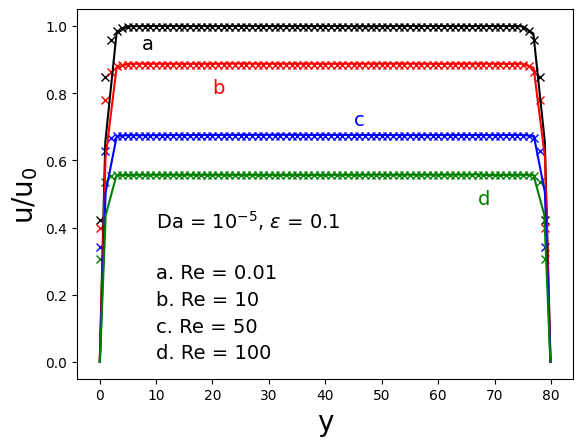

In [2]:
# Poiseuille flow - change reynolds number

import numpy as np
import time
import matplotlib.pyplot as plt


nx = 80
ny = 80
Reyn = [0.01, 10., 50., 100.]
y = []
u = []
for Re in Reyn:

    start = time.time()

    # Simulation parameters

    tau = 0.8
    omega = 1/tau
    cssq = 1/3
    nu = cssq*(tau - 0.5)

    tol = 1e-9
    relerror = 1

    eps = 0.1
    Da = 1e-5
    H = ny + 1
    umax = Re*nu/H
    K = Da*H**2 # eqna 5
    Feps = 1.75/(150*eps**3)**0.5

    c0 = 0.5*(1 + eps*0.5*nu/K)
    c1 = eps*0.5*Feps/(K**0.5)

    # D2Q9 lattice arrangement
    ndir = 9
    w = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
    cx = np.array([0, 1, -1, 0, 0, 1, -1, -1, 1])
    cy = np.array([0, 0, 0, 1, -1, 1, 1, -1, -1])

    # Simulation initialisation
    rho = np.ones((nx, ny))

    ux = np.zeros((nx, ny))
    uy = np.zeros((nx, ny))
    uxold = np.zeros((nx, ny))
    uyold = np.zeros((nx, ny))
    feq = np.zeros((ndir, nx, ny))
    Fdist = np.zeros((ndir,nx,ny))

    Gx = 0.01875*Re/10
    # print('Gx =', Gx)
    Fx = eps*Gx

    for k in range(ndir):
        feq[k, :, :] = w[k]
        dotprodF = cx[k]*Fx
        Fdist[k, :, :] = w[k]*rho*(1-0.5*omega)*dotprodF/cssq

    f = np.copy(feq)
    fold = np.copy(feq)

    t = 0

    print('Starting simulation for Re =',Re)

    # Simulation loop
    while relerror > tol:

        # Collision
        f = (1 - omega)*fold + omega*feq + Fdist

        # Streaming - Explicit version
        # automatically applies periodic boundary conditions in all edges of computation domain
        for k in range(ndir):
          fold[k, :, :] = np.roll(np.roll(f[k, :, :], cx[k], axis = 0), cy[k], axis = 1)

        # Boundary conditions
        # No-slip boundary condition on the bottom and top walls (in the y-axis)
        # Implemented by half-way bounce-back
        fold[3, :, 0] = f[4, :, 0] # is the 2nd 3 meant to be 4? yes
        fold[5, :, 0] = f[7, :, 0]
        fold[6, :, 0] = f[8, :, 0]

        fold[4, :, ny - 1] = f[3, :, ny - 1]
        fold[7, :, ny - 1] = f[5, :, ny - 1]
        fold[8, :, ny - 1] = f[6, :, ny - 1]

        # Macroscopic variables: density, velocity, forces
        rho = fold[0, :, :] + fold[1, :, :] + fold[2, :, ] + fold[3, :, :] + fold[4, :, :] + fold[5, :, :] + fold[6, :, :] + fold[7, :, :] + fold[8, :, :]
        # compute rho using eqn 3.1
        vx = np.zeros((nx, ny))
        vy = np.zeros((nx, ny))

        for k in range(ndir):
            vx += cx[k]*fold[k, :, :]
            vy += cy[k]*fold[k, :, :]


        vx = vx/rho + 0.5*eps*Gx
        vy /= rho
        vmagn = (vx**2 + vy**2)**0.5

        ux = vx / (c0 + (c0**2 + c1*vmagn)**0.5)
        uy = vy / (c0 + (c0**2 + c1*vmagn)**0.5)
        umagn = (ux**2 + uy**2)**0.5


        Fx = -eps*nu*ux/K - eps*Feps*umagn*ux/(K**0.5) + eps*Gx
        Fy = -eps*nu*uy/K - eps*Feps*umagn*uy/(K**0.5)

        # Equilibrium distribution function (+ force term)
        for k in range(ndir):
            dotprod = cx[k]*ux + cy[k]*uy # dot product between directions and u
            udotu = ux**2 + uy**2
            dotprodF = cx[k]*Fx + cy[k]*Fy # dot product between directions and F
            udotF = ux*Fx + uy*Fy # dot product between u and F
            feq[k, :, :] = w[k]*rho*(1 + dotprod/cssq + dotprod**2/(2*eps*cssq**2) - udotu/(2*eps*cssq))

            Fdist[k, :, :] = w[k]*rho*(1-0.5*omega)*(dotprodF/cssq + (dotprod*dotprodF)/(eps*cssq**2) - udotF/(eps*cssq))


        # Computing relative error
        num = ((ux - uxold)**2 + (uy - uyold)**2)**0.5
        relerror = np.max(num/umagn)

        uxold = ux
        uyold = uy

        t += 1

        if t % 1000 == 0:
            print(t, time.time()-start, relerror)

    print(t, relerror, umax, np.max(ux))

    umagn = np.sqrt(ux**2 + uy**2)

    y.append(umagn[nx//2, :]/umax)
    # u.append(umagn[nx//2, ny//2]/umax)

    print(umagn[nx//2, ny//2]/umax)


x = range(0, ny)
xy0 = np.array((0.00025339, 0.00019886, 0.012563, 0.65438, 0.037457, 0.97803, 0.062760, 0.99927, 0.11268, 1.0000, 0.16192, 1.0002, 0.18791, 0.99985, 0.23742, 0.99985, 0.26259, 0.99985, 0.33727, 1.0002, 0.36189, 0.99985, 0.38719, 0.99985, 0.46187, 0.99985, 0.48772, 0.99966,
                0.51193, 1.0000, 0.58648, 0.99908, 0.63667, 0.99966, 0.66157, 1.0002, 0.68646, 0.99985, 0.71163, 0.99985, 0.76128, 1.0000, 0.81175, 0.99985, 0.88670, 1.0000, 0.91132, 0.99966, 0.93608, 0.99946, 0.96070, 0.97765, 0.98614, 0.65381, 0.99872, -0.00018393))
x0 = xy0[::2]*80
y0 = xy0[1::2]
xy1 = np.array((0.00038358, 0.00076413, 0.013057, 0.60706, 0.037488, 0.87516, 0.062691, 0.88704, 0.087380, 0.88776, 0.16247, 0.88776, 0.18768, 0.88740, 0.21262, 0.88740, 0.31215, 0.88848, 0.33709, 0.88812, 0.36204, 0.88776, 0.43713, 0.88776, 0.46208, 0.88812,
                0.48728, 0.88740, 0.61150, 0.88812, 0.63696, 0.88776, 0.66139, 0.88812, 0.76143, 0.88740, 0.78612, 0.88776, 0.81209, 0.88812, 0.91136, 0.88740, 0.93579, 0.88776, 0.96125, 0.87552, 0.98645, 0.60778, 0.99854, 0.00069215))
x1 = xy1[::2]*80
y1 = xy1[1::2]
xy2 = np.array((0.00045559, 0.00069215, 0.013314, 0.50450, 0.038003, 0.67256, 0.062948, 0.67472, 0.087894, 0.67472, 0.23731, 0.67544, 0.26251, 0.67580, 0.28772, 0.67580, 0.43739, 0.67616, 0.46234, 0.67544, 0.48780, 0.67580,
                0.66164, 0.67508, 0.68736, 0.67508, 0.71179, 0.67508, 0.83601, 0.67544, 0.86198, 0.67508, 0.88693, 0.67508, 0.91136, 0.67544, 0.93605, 0.67544, 0.96176, 0.67256, 0.98620, 0.50522, 0.99854, 0.00069215))
x2 = xy2[::2]*80
y2 = xy2[1::2]
xy3 = np.array((0.00066503, 0.00024592, 0.013468, 0.43649, 0.037540, 0.55654, 0.063154, 0.55654, 0.087843, 0.55697, 0.21221, 0.55697, 0.23752, 0.55697, 0.26282, 0.55697, 0.41188, 0.55654, 0.43718, 0.55697, 0.46218, 0.55654,
                0.58655, 0.55697, 0.61216, 0.55740, 0.63716, 0.55697, 0.81183, 0.55740, 0.83621, 0.55827, 0.86214, 0.55611, 0.93589, 0.55697, 0.96089, 0.55654, 0.98496, 0.43735, 0.99823, 0.00076413))
x3 = xy3[::2]*80
y3 = xy3[1::2]
plt.plot(x, y[0], 'kx', label = "Re=0.01")
plt.plot(x, y[1], 'rx', label = "Re=10")
plt.plot(x, y[2], 'bx', label = "Re=50")
plt.plot(x, y[3], 'gx', label = "Re=100")
plt.plot(x0, y0, 'k', label = "Re=0.01 (ref)")
plt.plot(x1, y1, 'r', label = "Re=10 (ref)")
plt.plot(x2, y2, 'b', label = "Re=50 (ref)")
plt.plot(x3, y3, 'g', label = "Re=100 (ref)")
plt.text(10, 0.4, 'Da = $\mathregular{10^{-5}}$, $\epsilon$ = 0.1', fontsize = 14)
plt.text(10, 0.25, 'a. Re = 0.01', fontsize = 14)
plt.text(10, 0.17, 'b. Re = 10', fontsize = 14)
plt.text(10, 0.09, 'c. Re = 50', fontsize = 14)
plt.text(10, 0.01, 'd. Re = 100', fontsize = 14)
plt.text(7.5, 0.93, 'a', fontsize = 14, color = 'k')
plt.text(20, 0.8, 'b', fontsize = 14, color = 'r')
plt.text(45, 0.705, 'c', fontsize = 14, color = 'b')
plt.text(67, 0.47, 'd', fontsize = 14, color = 'g')
plt.xlabel('y', fontsize = 20)
plt.ylabel('$\mathregular{u/u_0}$', fontsize = 20)
plt.show()